# Final Project

## problem

`-` 자신이 어떤 회사를 운영하거나 회사의 데이터 관리자라고 가정해보자 (예를 들어, 온라인 쇼핑몰을 운영하거나 데이터 분석 컨설팅 업체를 설립한다고 생각해볼 수 있겠다).  

`-` 회사의 데이터를 관리 및 활용하는 관점에서 데이터베이스를 설계하고, 필요한 데이터 분석 정보를 생성하는 Project를 수행하시오.

`-` 보고서에는 다음과 같은 사항이 포함되어야 합니다.

1. 필요한 데이터 항목, 데이터로부터 얻어야 되는 정보

2. 데이터베이스 구조 (테이블 수 및 테이블들간의 관계)

3. 데이터 업로드 과정 (데이터 import 과정, SQL 문장 등)

4. 데이터베이스에 업로드된 데이터 요약 (요약 통계량, 표/그래프 활용)

5. 필요한 정보를 얻기 위한 데이터 분석 (데이터 분석 기법 활용)

6. 결론 및 프로젝트 수행 소감

`-` Project 보고서는 1개의 파일로 만들어 첨부하시오. 

`-` R, Python code는 보고서에 부록으로 넣으시오.

`-` 보고서 발표 및 제출 마감일 : 2022. 6. 14(화) 22:00

## 할 것 정리

`-` 주어진 데이터를 활용하여 질병 예측

`-` 예컨대 키, 몸무게, 혈압 등의 데이터를 가지고 혈색소에 문제가 있는지 판단

- 필요한 데이터 항목과 데이터로부터 얻어야 되는 정보

`-` 데이터로부터 고혈압이나 당뇨 등의 비율을 알 수 있다

`-` 최근 2개년인 2018년~2019년 까지의 데이터는 일단 DB로 만들고 필요한 컬럼만 뽑아서 사용하자

`-` 1개년도 데이터만 쓰는 것보다 n개년도 데이터를 쓰는 것이 데이터 특성상 더 무작위

- 데이터베이스 구조 (테이블 수 및 테이블들간의 관계)

`-` 결측치가 많은 데이터끼리 모아 테이블을 만든다

`-` 나머지 컬럼에 대해서는 성격상 비슷한 것끼리 묶는다(내과, 안과 등)

`-` 테이블의 관계는 외래키를 통해 설명

- 나머지 part는 그냥 하면 된다

- 그 외 link

`-` https://www.mfds.go.kr/brd/m_99/view.do?seq=46091

`-` https://www.index.go.kr/potal/main/EachDtlPageDetail.do?idx_cd=3051

## 패키지 import

In [1]:
import os
import time
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import statsmodels.formula.api as smf
from scipy import stats
import warnings

warnings.filterwarnings('ignore')

In [2]:
os.getcwd()

'C:\\Users\\Jaesu\\github_desktop\\statistical-database-project'

## 일련번호 Merge Test

`-` 건강검진 데이터와 진료내역 데이터의 가입자일련번호가 매칭되는지 확인

`-` 만약 안된다면 건강검진 데이터만 가지고 data mining을 통한 질병 predict 수행

`-` random이라 매칭 불가능ㅠㅠ

`-` 피검사가 제일 힘드니 나머지 피쳐로 피검사의 결과를 예측하는 모델을 만들자

`-` 만약, 위의 것만 한다면 총 인구수와 건강보험 데이터는 필요가 없다

`-` 사람들의 건강 check 및 피쳐별 관계 시각화를 통한 분석(허리둘레와 혈압간의 관계 -> 허리둘레가 길면 고혈압을 조심하세요)

`-` 사람들의 건강 향상을 위한 보험료가 어떻게 쓰이는지 check하고 머신러닝 모델을 통해 검진하기 전에 확률을 predict하여

`-` 확률이 낮으면 굳이 검진하지 않을 것을 추천해주고 확률이 높다면 검진할 것을 추천하여 사람들의 건강 관리 

`-` 피 검사 제외의 간단한 검사를 하고 검진 결과 혈액 관련 문제가 생길 확률이 높다 판단되면 피 검사를 추천하는 시스템 구성

`-` 위의 흐름으로 해보자

## NHIS 데이터 불러오기

`-` 국민건강검진 데이터는 2018~2019년의 데이터를 하나의 파일로 묶겠다

`-` 결손치 유무, 제3대구치(사랑니) 이상, 치아마모증유무 변수는 2020년 데이터에는 존재하지 않는다

`-` 구강검진 수검여부 변수는 유용하지 않다(예컨대 치석 변수가 NA가 아니라면 당연히 구강검진을 수검했음)

`-` 또한, 2018년과 2019년 데이터에서도 컬럼만 존재하지 미시행하였기 때문에 drop 하겠다

`-` 가입자 일련번호를 1~2000000으로 set 해주고 데이터 공개일자 변수는 기준년도 변수가 있으므로 drop 하겠다

In [374]:
def remove_space(df: pd.DataFrame) -> pd.DataFrame:
    """컬럼명에 포함된 공백을 제거한 데이터프레임을 반환하는 함수"""
    df = df.rename(columns = dict(zip(df.columns, [column.replace(' ', '') for column in df.columns]))) 
    return df

In [441]:
def get_NHIS_dataframe() -> pd.DataFrame:
    """
    NHIS_2018 ~ NHIS_2019 csv 파일을 불러온 후 간단한 전처리를 수행하고 merge 하여 반환하는 함수
    
    *--- 전처리 ---*
    1. NHIS_2019 데이터에 중복행이 있어 이를 제거
    2. csv 파일의 컬럼명을 서로 동일하게 해주기 위해 각 csv 파일의 컬럼명에 있는 공백을 제거
    
    *--- Data Path ---*
    .(current directory)
    |--- Data
        |--- NHIS_OPEN_GJ_2018.csv
        |--- NHIS_OPEN_GJ_2019.csv
    """
    df = pd.concat([
                    remove_space(pd.read_csv('./Data/NHIS_OPEN_GJ_2018.csv', encoding='euc=kr')), ## 2018년

                    remove_space(pd.read_csv('./Data/NHIS_OPEN_GJ_2019.csv', encoding='euc=kr', on_bad_lines='skip').
                                    drop_duplicates(). ## 중복행 제거
                                    assign(**{'가입자 일련번호': lambda df: df['가입자 일련번호'] + 1000000})), ## 2019년도는 일련번호 1000001부터 시작

                   ]).reset_index().drop('index', axis=1)
    return df

In [442]:
_df = get_NHIS_dataframe() ## 시간이 조금 걸린다

- 데이터프레임의 간단한 정보

In [377]:
_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 34 columns):
 #   Column        Dtype  
---  ------        -----  
 0   기준년도          int64  
 1   가입자일련번호       int64  
 2   성별코드          int64  
 3   연령대코드(5세단위)   int64  
 4   시도코드          int64  
 5   신장(5Cm단위)     int64  
 6   체중(5Kg단위)     int64  
 7   허리둘레          float64
 8   시력(좌)         float64
 9   시력(우)         float64
 10  청력(좌)         float64
 11  청력(우)         float64
 12  수축기혈압         float64
 13  이완기혈압         float64
 14  식전혈당(공복혈당)    float64
 15  총콜레스테롤        float64
 16  트리글리세라이드      float64
 17  HDL콜레스테롤      float64
 18  LDL콜레스테롤      float64
 19  혈색소           float64
 20  요단백           float64
 21  혈청크레아티닌       float64
 22  (혈청지오티)AST    float64
 23  (혈청지오티)ALT    float64
 24  감마지티피         float64
 25  흡연상태          float64
 26  음주여부          object 
 27  구강검진수검여부      object 
 28  치아우식증유무       float64
 29  결손치유무         object 
 30  치아마모증유무       obje

- 결측치

In [443]:
_df.isnull().sum()

기준년도                  0
가입자일련번호               0
성별코드                  0
연령대코드(5세단위)           0
시도코드                  0
신장(5Cm단위)             0
체중(5Kg단위)             0
허리둘레                817
시력(좌)               448
시력(우)               454
청력(좌)               398
청력(우)               395
수축기혈압             11154
이완기혈압             11155
식전혈당(공복혈당)        11438
총콜레스테롤          1333695
트리글리세라이드        1333708
HDL콜레스테롤        1333713
LDL콜레스테롤        1346974
혈색소               11446
요단백               20876
혈청크레아티닌           11432
(혈청지오티)AST        11428
(혈청지오티)ALT        11429
감마지티피             11439
흡연상태                400
음주여부             710025
구강검진수검여부              0
치아우식증유무         1202328
결손치유무           1000000
치아마모증유무         1000000
제3대구치(사랑니)이상    1000000
치석              1224690
데이터공개일자               0
dtype: int64

- 전처리

`-` 연령대를 5세 단위에서 10세 단위로 변경하겠다

In [445]:
def set_age(df: pd.DataFrame) -> pd.DataFrame:
    """연령대 코드(5세 단위)를 연령대(10세 단위)로 변경하여 반환"""
    def f(x):
        tmp = (x - 1) // 2
        if tmp == 0:
            return '10대미만'
        elif tmp == 8:
            return '80대이상'
        else:
            return f'{tmp}0대'

    ## apply function    
    age_df = df.apply(f)
    return age_df

In [446]:
_df['연령대'] = set_age(_df['연령대코드(5세단위)'])

`-` 각 년도마다 5000개씩 무작위로 추출하겠다

In [384]:
def sampling_df(df_: pd.DataFrame, n: int) -> pd.DataFrame:
    """
    각 년도마다 무작위로 n개 row 추출 -> 총 2n개
    """
    df = df_.copy()
    df = pd.concat([df.query('기준년도 == @year').sample(n=n, replace=False, random_state=22) for year in range(2018, 2020)])
    df = df.sort_values(by=['가입자일련번호'])
    df = df.reset_index().drop('index', axis=1)
    return df

In [554]:
df = sampling_df(_df, n=5000) 

`-` 위에서 언급했듯이 결손치 유무, 제3대구치(사랑니) 이상, 치아마모증유무, 데이터 공개일자 변수는 drop 하겠다

In [455]:
def drop_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    drop_columns 목록에 존재하는 변수를 drop한 데이터프레임을 반환하는 함수(원본이 변한다)
    """
    drop_columns = ['결손치유무', '제3대구치(사랑니)이상', '치아마모증유무', '데이터공개일자', '구강검진수검여부']
    for col in drop_columns:
        try:
            df = df.drop([col], axis=1)        
        except:
            pass
    return df

In [555]:
df = drop_columns(df) 

`-` 음주 여부, 치석변수는 unique한 값으로 `0, 1, 'Y', 'N'` 를 가지는데 편의상 `'Y' -> 1`로 `'N' -> 0`으로 바꿔주겠다

In [556]:
def bool2int(df: pd.DataFrame) -> pd.DataFrame:
    """변수가 가지는 값에서 'Y' -> 1, 'N' -> 0으로 mapping하고 해당 데이터프레임을 반환(원본이 변한다)"""
    columns = ['음주여부', '치석']
    for col in columns:
        df[col] = df[col].map({'Y':1, 'N':0, 1:1, 0:0})
    return df

In [557]:
df = bool2int(df)

- 테이블 나누기(MedicalCheckup)

`-` 전처리가 끝난 csv 파일은 db로 올려야 한다!!!(물론 테이블을 나누고)

`-` 각 테이블에는 `기본키`가 있어야 하는데 `기본키는 일련번호`를 사용할 것이다

`-` `시도코드`와 `시도이름` 속성을 갖는 `Region` 테이블을 만들겠다(`시도코드 -> 기본키`)

`-` 결측치가 많은 컬럼은 `총콜레스테롤, 트리글리세라이드, HDL콜레스테롤, LDL콜레스테롤, 치아우식증유무, 치석, 음주여부`이다

`-` 컬럼의 속성을 콜레스테롤과 치아(Tooth)로 나누어 테이블을 2개 만들겠다

`-` `수축기혈압, 이완기혈압, 식전혈당(공복혈당)`을 `Blood_Pressure_Sugar` 테이블로 만들겠다

`-` `요단백, 혈색소, 감마지티피, 혈청크레아티닌, (혈청지오티)AST, (혈청지오티)ALT`을 ` Enzyme` 테이블로 만들겠다

`-` 나머지에 해당하는 `기준년도, 가입자일련번호, 성별코드, 연령대코드(5세단위), 시도코드, 신장(5Cm단위), 체중(5Kg단위), 허리둘레, 시력(좌), 시력(우), 청력(좌), 청력(우), 흡연상태, 음주여부`를 하나의 테이블로 만들겠다

`-` 여기서 `가입자일련번호 -> 기본키`, `시도코드 -> 외래키` 이다

`-` 컬럼의 type을 변경해주겠다(`ex: 1.0 -> 1`)

- Region table

In [33]:
def get_region_table() -> pd.DataFrame:
    df = pd.DataFrame({'Region_Code':[0, 11, 42, 26, 43, 27, 44, 28, 45, 29, 46, 30, 47, 31, 48, 36, 49, 41],
                       'Region_Name':['전국', '서울특별시', '강원도', '부산광역시', '충청북도', '대구광역시', '충청남도',
                                      '인천광역시', '전라북도', '광주광역시', '전라남도', '대전광역시', '경상북도',
                                      '울산광역시', '경상남도', '세종특별자치시', '제주특별자치도', '경기도']})
    return df

In [34]:
region_table = get_region_table()

- Tooth table

`-` 치석 변수와 치아우식증유무 변수 중 하나라도 NA가 아닌 데이터로 table을 구성하겠다

In [390]:
def get_tooth_table(df: pd.DataFrame) -> pd.DataFrame:
    """치아우식증 유무 변수와 치석 변수 둘다 NA가 아닌 행만 추출하고 table 구성"""
    df_ = df.copy()
    df_ = df_.loc[(df_['치아우식증유무'].isnull()) & (df_['치석'].isnull()) == False, ['가입자일련번호', '치아우식증유무', '치석']] ## 가입자일련번호는 기본키
    df_ = df_.reset_index().drop('index', axis=1)
    return df_

In [391]:
tooth_table = get_tooth_table(df)

In [392]:
tooth_table.shape

(4036, 3)

- Cholesterol table

In [393]:
def get_cholesterol_table(df: pd.DataFrame) -> pd.DataFrame:
    """
    가입자일련번호, 총콜레스테롤, 트리글리세라이드, HDL콜레스테롤, LDL콜레스테롤 변수로 table 구성
    """
    columns = ['총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤']
    df_ = df.copy()
    df_ = df_.dropna(how='all', subset=columns) ## columns가 모두 NA인 행은 drop
    df_ = df_[['가입자일련번호'] + columns] ## 가입자일련번호는 기본키
    df_ = df_.reset_index().drop('index', axis=1)
    return df_

In [394]:
cholesterol_table = get_cholesterol_table(df)

In [395]:
cholesterol_table.shape

(3388, 5)

- Blood Pressure and Sugar table

In [396]:
def get_blood_pressure_sugar_table(df: pd.DataFrame) -> pd.DataFrame:
    """
    가입자일련번호, 수축기혈압, 이완기혈압, 식전혈당(공복혈당) 변수로 table 구성
    """
    columns = ['수축기혈압', '이완기혈압', '식전혈당(공복혈당)'] 
    df_ = df.copy()
    df_ = df_[['가입자일련번호'] + columns] ## 가입자일련번호는 기본키
    return df_

In [397]:
blood_pressure_sugar_table = get_blood_pressure_sugar_table(df)

In [398]:
blood_pressure_sugar_table.shape

(10000, 4)

- Enzyme table

In [399]:
def get_Enzyme_table(df: pd.DataFrame) -> pd.DataFrame:
    """
    혈색소, 요단백, 감마지티피, 혈청크레아티닌, (혈청지오티)AST, (혈청지오티)ALT 변수로 table 구성
    """
    columns = ['혈색소', '요단백', '감마지티피', '혈청크레아티닌', '(혈청지오티)AST', '(혈청지오티)ALT'] 
    df_ = df.copy()
    df_ = df_[['가입자일련번호'] + columns] ## 가입자일련번호는 기본키
    return df_

In [400]:
enzyme_table = get_Enzyme_table(df)

In [401]:
enzyme_table.shape

(10000, 7)

- Basic Health table

In [402]:
def get_basic_health_table(df: pd.DataFrame) -> pd.DataFrame:
    """
    *--- columns --**
    기준년도, 가입자일련번호, 성별코드, 연령대코드(5세단위),
    시도코드, 신장(5Cm단위), 체중(5Kg단위), 허리둘레,
    시력(좌), 시력(우), 청력(좌), 청력(우), 흡연상태, 음주여부
    
    위에 해당하는 변수들로 table 구성하고 반환
    """
    columns = ['기준년도', '성별코드', '연령대', '시도코드',
               '신장(5Cm단위)', '체중(5Kg단위)', '허리둘레',
               '시력(좌)', '시력(우)', '청력(좌)', '청력(우)',
               '흡연상태', '음주여부']
    
    df_ = df.copy()
    df_ = df_[['가입자일련번호'] + columns] ## 가입자일련번호는 기본키
    return df_

In [403]:
basic_health_table = get_basic_health_table(df)

In [404]:
basic_health_table.shape

(10000, 14)

## DB 생성 및 데이터 업로드

- 변수이름 영문으로 변경

`-` 혹시 모를 error를 위해 테이블의 컬러명을 모두 영문으로 바꾸겠다

In [11]:
def get_name_dict() -> dict:
    """변수 각각의 한글명과 영문명 사전을 반환"""
    name_dict = {'기준년도':'Year',
                 '가입자일련번호':'User_ID',
                 '성별코드':'Sex',
                 '연령대코드(5세단위)':'Age_Group2',
                 '연령대':'Age_Group',
                 '시도코드':'Region_Code',
                 '신장(5Cm단위)':'Height',
                 '체중(5Kg단위)':'Weight',
                 '허리둘레':'Waist',
                 '시력(좌)':'Sight_Left',
                 '시력(우)':'Sight_Right',
                 '청력(좌)':'Hear_Left',
                 '청력(우)':'Hear_Right',
                 '수축기혈압':'BP_High',
                 '이완기혈압':'BP_Low',
                 '식전혈당(공복혈당)':'BLDS',
                 '총콜레스테롤':'Total_Cholesterol',
                 '트리글리세라이드':'Triglyceride',
                 'HDL콜레스테롤':'HDL_Cholesterol',
                 'LDL콜레스테롤':'LDL_Cholesterol',
                 '혈색소':'Hemoglobin',
                 '요단백':'Proteinuria',
                 '혈청크레아티닌':'Serum_Creatinine',
                 '(혈청지오티)AST':'SGOT_AST',
                 '(혈청지오티)ALT':'SGOT_ALT',
                 '감마지티피':'Gamma_GTP',
                 '흡연상태':'Smoking_Type',
                 '음주여부':'Alcohol_YN',
                 '치아우식증유무':'CRS_YN',
                 '치석':'Tartar_YN'}
    
    return name_dict

In [12]:
def rename_columns_to_korean(df_list: pd.DataFrame) -> None:
    """컬럼명을 한글로 바꿔주는 함수(원본이 변한다)"""
    name_dict = get_name_dict()
    name_dict = dict(zip(name_dict.values(), name_dict.keys()))
    for df in df_list:
        df.rename(columns=name_dict, inplace=True)

In [13]:
def rename_columns_to_english(df_list: pd.DataFrame) -> None:
    """컬럼명을 영문으로 바꿔주는 함수(원본이 변한다)"""
    name_dict = get_name_dict()  
    for df in df_list:
        df.rename(columns=name_dict, inplace=True)

In [408]:
rename_columns_to_english([tooth_table,
                           cholesterol_table,
                           blood_pressure_sugar_table,
                           enzyme_table,
                           basic_health_table])

In [594]:
rename_columns_to_english([df])

- DB 생성 및 테이블 업로드

In [2]:
## ./Data 폴더에 MedicalCheckup 데이터베이스를 생성하고 연결
conn = sqlite3.connect('./Data/MedicalCheckup.db', isolation_level=None)

In [3]:
## 커서 생성
cur = conn.cursor()

In [240]:
# conn.close() ## 연결 해제

- region table 생성

In [18]:
## Region 테이블 생성하기
sql = """CREATE TABLE IF NOT EXISTS Region  
        (
        Region_Code INTEGER NOT NULL, 
        Region_Name TEXT NOT NULL,
        PRIMARY KEY (Region_Code)
        )
        """

cur.execute(sql)

In [19]:
# sql = 'DROP TABLE Region' ## table 삭제
# cur.execute(sql)

In [42]:
region_table.to_csv('./Data/Region.csv', index=False)

In [21]:
pd.read_csv('https://raw.githubusercontent.com/gkswotn9999/data/main/Region.csv').\
to_sql('Region', conn, method='multi', if_exists='append', index=False)

18

- basic health table 생성

In [460]:
## Basic_Health 테이블 생성하기
sql = """CREATE TABLE IF NOT EXISTS Basic_Health  
        (
        User_ID INTEGER NOT NULL, 
        Year INTEGER NOT NULL,
        Sex INTEGER NOT NULL,
        Age_Group INTEGER NOT NULL,
        Region_Code INTEGER NOT NULL,
        Height INTEGER NOT NULL,
        Weight INTEGER NOT NULL,
        Waist REAL,
        Sight_Left REAL,
        Sight_Right REAL,
        Hear_Left REAL,
        Hear_Right REAL,
        Smoking_Type INTEGER,
        Alcohol_YN INTEGER,
        PRIMARY KEY (User_ID),
        FOREIGN KEY (Region_Code) REFERENCES Region (Region_Code) 
        )
        """

cur.execute(sql)

In [461]:
# sql = 'DROP TABLE Basic_Health' ## table 삭제
# cur.execute(sql)

In [415]:
basic_health_table.to_csv('./Data/Basic_Health.csv', index=False)

In [462]:
pd.read_csv('https://raw.githubusercontent.com/gkswotn9999/data/main/Basic_Health.csv').\
to_sql('Basic_Health', conn, method='multi', if_exists='append', index=False)

10000

- tooth table 생성

In [465]:
## Tooth 테이블 생성하기
sql = """CREATE TABLE IF NOT EXISTS Tooth  
        (
        User_ID INTEGER NOT NULL, 
        CRS_YN INTEGER,
        Tartar_YN INTEGER,
        PRIMARY KEY (User_ID),
        FOREIGN KEY (User_ID) REFERENCES Basic_Health (User_ID) 
        )
        """

cur.execute(sql)

In [464]:
# sql = 'DROP TABLE Tooth' ## table 삭제
# cur.execute(sql)

In [416]:
tooth_table.to_csv('./Data/Tooth.csv', index=False)

In [466]:
pd.read_csv('https://raw.githubusercontent.com/gkswotn9999/data/main/Tooth.csv').\
to_sql('Tooth', conn, method='multi', if_exists='append', index=False)

4036

- cholesterol table 생성

In [468]:
## Cholesterol 테이블 생성하기
sql = """CREATE TABLE IF NOT EXISTS Cholesterol 
        (
        User_ID INTEGER NOT NULL, 
        Total_Cholesterol REAL,
        Triglyceride REAL,
        HDL_Cholesterol REAL,
        LDL_Cholesterol REAL,
        PRIMARY KEY (User_ID),
        FOREIGN KEY (User_ID) REFERENCES Basic_Health (User_ID) 
        )
        """

cur.execute(sql)

In [470]:
# sql = 'DROP TABLE Cholesterol' ## table 삭제
# cur.execute(sql)

In [417]:
cholesterol_table.to_csv('./Data/Cholesterol.csv', index=False)

In [469]:
pd.read_csv('https://raw.githubusercontent.com/gkswotn9999/data/main/Cholesterol.csv').\
to_sql('Cholesterol', conn, method='multi', if_exists='append', index=False)

3388

- blood pressure and sugar table 생성

In [472]:
## Blood_Pressure_Sugar 테이블 생성하기
sql = """CREATE TABLE IF NOT EXISTS Blood_Pressure_Sugar 
        (
        User_ID INTEGER NOT NULL, 
        BP_High INTEGER,
        BP_Low INTEGER,
        BLDS INTEGER,
        PRIMARY KEY (User_ID),
        FOREIGN KEY (User_ID) REFERENCES Basic_Health (User_ID) 
        )
        """

cur.execute(sql)

In [474]:
# sql = 'DROP TABLE Blood_Pressure_Sugar' ## table 삭제
# cur.execute(sql)

In [418]:
blood_pressure_sugar_table.to_csv('./Data/Blood_Pressure_Sugar.csv', index=False)

In [473]:
pd.read_csv('https://raw.githubusercontent.com/gkswotn9999/data/main/Blood_Pressure_Sugar.csv').\
to_sql('Blood_Pressure_Sugar', conn, method='multi', if_exists='append', index=False)

10000

- enzyme table 생성

In [476]:
## Enzyme 테이블 생성하기
sql = """CREATE TABLE IF NOT EXISTS Enzyme 
        (
        User_ID INTEGER NOT NULL, 
        Hemoglobin REAL,
        Proteinuria INTERGER,
        Gamma_GTP INTERGER,
        Serum_Creatinine REAL,
        SGOT_AST INTEGER,
        SGOT_ALT INTEGER,
        PRIMARY KEY (User_ID),
        FOREIGN KEY (User_ID) REFERENCES Basic_Health (User_ID) 
        )
        """

cur.execute(sql)

In [477]:
# sql = 'DROP TABLE Enzyme' ## table 삭제
# cur.execute(sql)

In [419]:
enzyme_table.to_csv('./Data/Enzyme.csv', index=False)

In [478]:
pd.read_csv('https://raw.githubusercontent.com/gkswotn9999/data/main/Enzyme.csv').\
to_sql('Enzyme', conn, method='multi', if_exists='append', index=False)

10000

## 시각화

`-` 키, 몸무게, 허리둘레, 혈압(수축기, 이완기)과 같은 항목은 집에서도 간단히 측정이 가능하다

`-` 요단백 같은 경우도 소변에서 거품이 많이 나오는지 확인함으로써 판단이 가능하다

`-` 하지만 혈액검사를 통해 얻을 수 있는 항목은 집에서 측정이 불가능하여 병원을 통해 측정해야 하며 비용이 저렴하지 않다

`-` 집에서도 간단히 얻을 수 있는 정보를 통해 혈액 

`-` 연령대, 성별, 키, 몸무게, 허리둘레, 흡연상태, 음주여부, 치석, 혈압(수축기, 이완기), 시력, 청력

In [4]:
sns.set_theme(style='white')

In [5]:
matplotlib.rcParams['font.family'] = 'Malgun Gothic' # 한글이 깨지지 않도록 설정
matplotlib.rcParams['axes.unicode_minus'] = False    # 한글이 깨지지 않도록 설정

- 변수 설명

`-` 총 콜레스테롤: 정상치는 150~250mg/dL 

`-` HDL 콜레스테롤: 정상치는 30~65mg/dL

`-` LDL 콜레스테롤: 170mg/dL 이상일 경우 일반적으로 고LDL혈증
 
`-` 혈색소: 정상치는 100ml당 12g에서 18g (낮으면 빈혈, 높으면 혈당과다)

`-` 혈청크레아티닌: 정상치 0.8~1.7mg/dL

`-` 혈청지오티: 정상치 0~40IU/L

`-` 감마지티피: 정상치 남성 11\~63IU/L, 여성 8\~35IU/L

`-` 요단백: 1은 음성, 2는 약양성, 30mg/dL은 +1, 100mg/dL은 경우 +2, 300mg/dL은 +3, 1000mg/dL은 +4

`-` 고혈압은 우리나라 기준 수축기 혈압 140mmHg 이상이거나 이완기 혈압 90mmHg 이상인 경우라고 한다

`-` 당뇨병의 진단에 있어 혈당치의 기준은 공복 혈당치 126 mg/dL 이상(고혈당)

`-` 공복혈당이 너무 낮으면(60 mg/dL이하) 저혈당으로 간주하나 거의 없음(아마도)

`-` 필요없는 것까지 추가하지 말기(양 보단 질)

`-` 성별 비율, 연령대 비율 시각화 ---> 이런 것들은 의미 없다(보고서 자리만 차지)

`-` 데이콘 베이스라인 EDA 코드 참고해보자

- 시각화 할 목록

`-` 머신러닝 모델은 피검사 하지 않아도 예측할 수 있게 하는 것이 목표

`-` 연령대별(시도별) 혈압과 혈당변화

`-` 키, 몸무게, 허리둘레, 혈압, 혈당간의 산점도(기본 목록)

`-` 피검사 해야 알 수 있는 것: 혈당, 혈색소, 콜레스테롤, 트리글리세라이드, 혈청크레아티닌, 지오티와 지티피

`-` 피검사 목록에서 이상치 범위 구해놓기(ex: 수축기혈압 130이상은 고혈압)

`-` 일단 상관관계 plot으로 시각화

`-` 기본 목록간의 상관계수는 당연히 높을테니 하나만 뽑아서(허리둘레로 할 것임) 피검사 목록과 시각화하기

`-` 머신러닝 모델은 피검사 한 경우와 안 한 경우로 나누고

`-` 한 경우는 사용자가 알고있는 수치를 입력하게 하자(어떤것을 알고 어떤것을 모르는지 모르므로 각 경우에 대해 모델을 각각 만들어놓아야 함)

- 그 외 목록

`-` 본인의 건강이 상위 몇% 인지 알 수 있도록 하기

`-` 아래에 `이런 것도 괜찮은 듯` check 하기

### 범주형 변수

- convert sql to dataframe

In [6]:
def sql_to_df(cursor, sql) -> pd.DataFrame:
    """sql문을 실행한 결과를 데이터프레임으로 만들어 반환하는 함수"""
    result = cursor.execute(sql) ## sql문 실행
    df = pd.DataFrame(result.fetchall()) ## 실행한 sql문의 결과를 데이터프레임으로 변환
    df.columns = [column_list[0] for column_list in result.description] ## 컬럼명 생성
    return df

In [7]:
def get_all_df(cur, table_list: list) -> pd.DataFrame:
    """table list에 속하는 table을 outer join하여 데이터프레임으로 반환"""
    df = None
    for table in table_list:
        sql = 'SELECT * FROM ' + table
        if df is not None:
            df = df.merge(sql_to_df(cur, sql), how='outer')
        else:
            df = sql_to_df(cur, sql)
    return df

- 시각화 함수

In [15]:
def int2str(df: pd.DataFrame) -> pd.DataFrame:
    """숫자로 인코딩된 범주형 변수를 object type으로 변경한 데이터프레임을 반환(원본이 바뀐다)"""
    features = ['Sex', 'Hear_Left', 'Hear_Right',
                'Smoking_Type', 'Alcohol_YN', 'Proteinuria',
                'CRS_YN', 'Tartar_YN', 'Year']
    for feature in features:
        try:
            df[feature] = df[feature].astype('str')
        except:
            pass
    return df

In [108]:
table_list = ['Basic_Health', 'Tooth', 'Cholesterol', 'Blood_Pressure_Sugar', 'Enzyme']

In [109]:
tmp = get_all_df(cur, table_list)

In [110]:
temp = get_all_df(cur, table_list)

In [111]:
tmp = int2str(tmp)

In [112]:
rename_columns_to_korean([tmp]) ## DB에서 꺼내오고 시각화할 땐 다시 한글로 바꿀까 말까

In [113]:
rename_columns_to_korean([temp])

In [114]:
tmp['청력(우)'] = tmp['청력(우)'].apply(lambda x: 2 if x == 3 else x) ## 3으로 인코딩된 것을 2로 변경
temp['청력(우)'] = temp['청력(우)'].apply(lambda x: 2 if x == 3 else x) ## 3으로 인코딩된 것을 2로 변경

In [115]:
tmp['연령대(20세단위)'] = tmp['연령대'].map({'20대':'20~30대',
                                             '30대':'20~30대',
                                             '40대':'40~50대',
                                             '50대':'40~50대',
                                             '60대':'60대이상',
                                             '70대':'60대이상',
                                             '80대이상':'60대이상'})

In [116]:
def show_crosstab(df_: pd.DataFrame, var1: str, var2: str, ax=None) -> None:
    df = df_.copy()
    df = df.dropna(subset=[var1]) ## NA drop
    df = df.loc[df[var1] != 'nan', :] ## string NA drop
    df = df.reset_index()
    table = pd.crosstab(df[var1], df[var2])
    table_prob = table.apply(lambda x: x*100 / sum(x), axis=0) # 상대도수를 구함
    table_prob.T.plot.bar(stacked=True, rot=0, figsize=(14 , 16), ax=ax, title=var1)

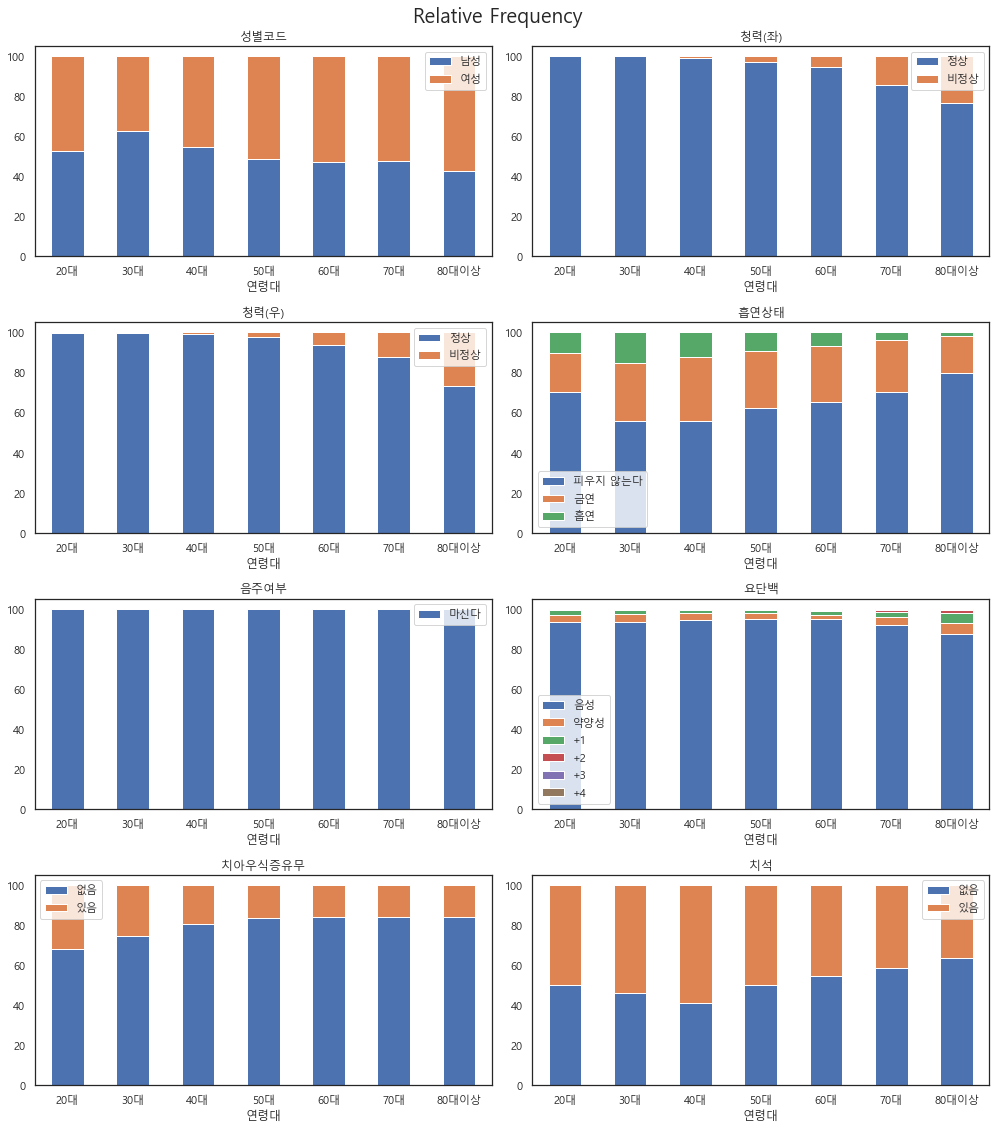

In [602]:
fig, axs = plt.subplots(4, 2)
features = ['성별코드', '청력(좌)', '청력(우)', '흡연상태', '음주여부', '요단백', '치아우식증유무', '치석']
legend = [['남성', '여성'],
          ['정상', '비정상'],
          ['정상', '비정상'],
          ['피우지 않는다', '금연', '흡연'],
          ['마신다', '마시지 않는다'],
          ['음성', '약양성', '+1', '+2', '+3', '+4'],
          ['없음', '있음'],
          ['없음', '있음']]

for i, ax in enumerate(axs.flatten()):
    show_crosstab(tmp, var1=features[i], var2='연령대', ax=ax)
    ax.legend(legend[i])

## fig option
fig.suptitle('Relative Frequency', fontsize=20)
fig.tight_layout()
plt.savefig('./Data/빈도표.png', bbox_inches='tight')

### 양적 변수

In [117]:
def get_not_outlier_index(df: pd.DataFrame, z:float = 3.0) -> list:
    """
    inpuut의 모든 컬럼에 대해 이상점이 아닌 인덱스 공통부분 list를 반환하는 함수
    """
    not_outlier_idx = (np.abs(stats.zscore(df)) < z).all(axis=1)
    return not_outlier_idx

In [118]:
def hist_plot(df_: pd.DataFrame, var_list: list, save_full_path: 'str') -> None:
    fig, axs = plt.subplots(5, 2, figsize=(16, 20)) 
    for i, ax in enumerate(axs.flatten()):
        try:
            var = var_list[i]

            ## preprocessing
            df = df_.copy()
            df = df[[var]]
            df = df.dropna()
            df = df.loc[df[var] != 'nan', :] ## string NA drop
            idx = get_not_outlier_index(df[[var]], z=5.0) ## 잘못 기입된 값에 가까운 이상점 제거
            df = df[idx] 

            ## find interval of normal value -> [lower bound, upper bound]
            bins = np.linspace(int(df[var].min()), int(df[var].max()), 50) ## 전체 구간 50등분 
            l, u = normal_value[var]
            bar_values_to_label = np.linspace(l, u, max((u - l)//5, 25))

            ## get the indices of hist that contains normal values(=bar_values_to_label)
            patch_indices = np.digitize([bar_values_to_label], bins)[0]
            p = df.plot(kind='hist', bins=bins, alpha=0.5, color='red', edgecolor='none', legend=False, fontsize=15, ax=ax)
            ax.set_title(var, fontdict={'fontsize': 15})

            for patch_index in patch_indices:
                p.patches[patch_index].set_facecolor('blue')
                p.patches[patch_index].set_alpha(0.5)
        except:
            pass
        
    fig.suptitle('Normal(blue) and Abnormal(red)', fontsize=30)
    fig.tight_layout()
    plt.savefig(save_full_path, bbox_inches='tight')

In [122]:
normal_value = {'식전혈당(공복혈당)':[70, 110],
                 '총콜레스테롤':[150, 250],
                 '트리글리세라이드':[30, 135],
                 'HDL콜레스테롤':[30, 65],
                 'LDL콜레스테롤':[0, 130],
                 '혈색소':[12, 18],
                 '혈청크레아티닌':[0.5, 1.4],
                 '(혈청지오티)AST':[0, 40],
                 '(혈청지오티)ALT':[0, 40],
                 '감마지티피':[9, 49]}

In [123]:
features = ['식전혈당(공복혈당)', '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤',
            '혈색소', '혈청크레아티닌', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피']

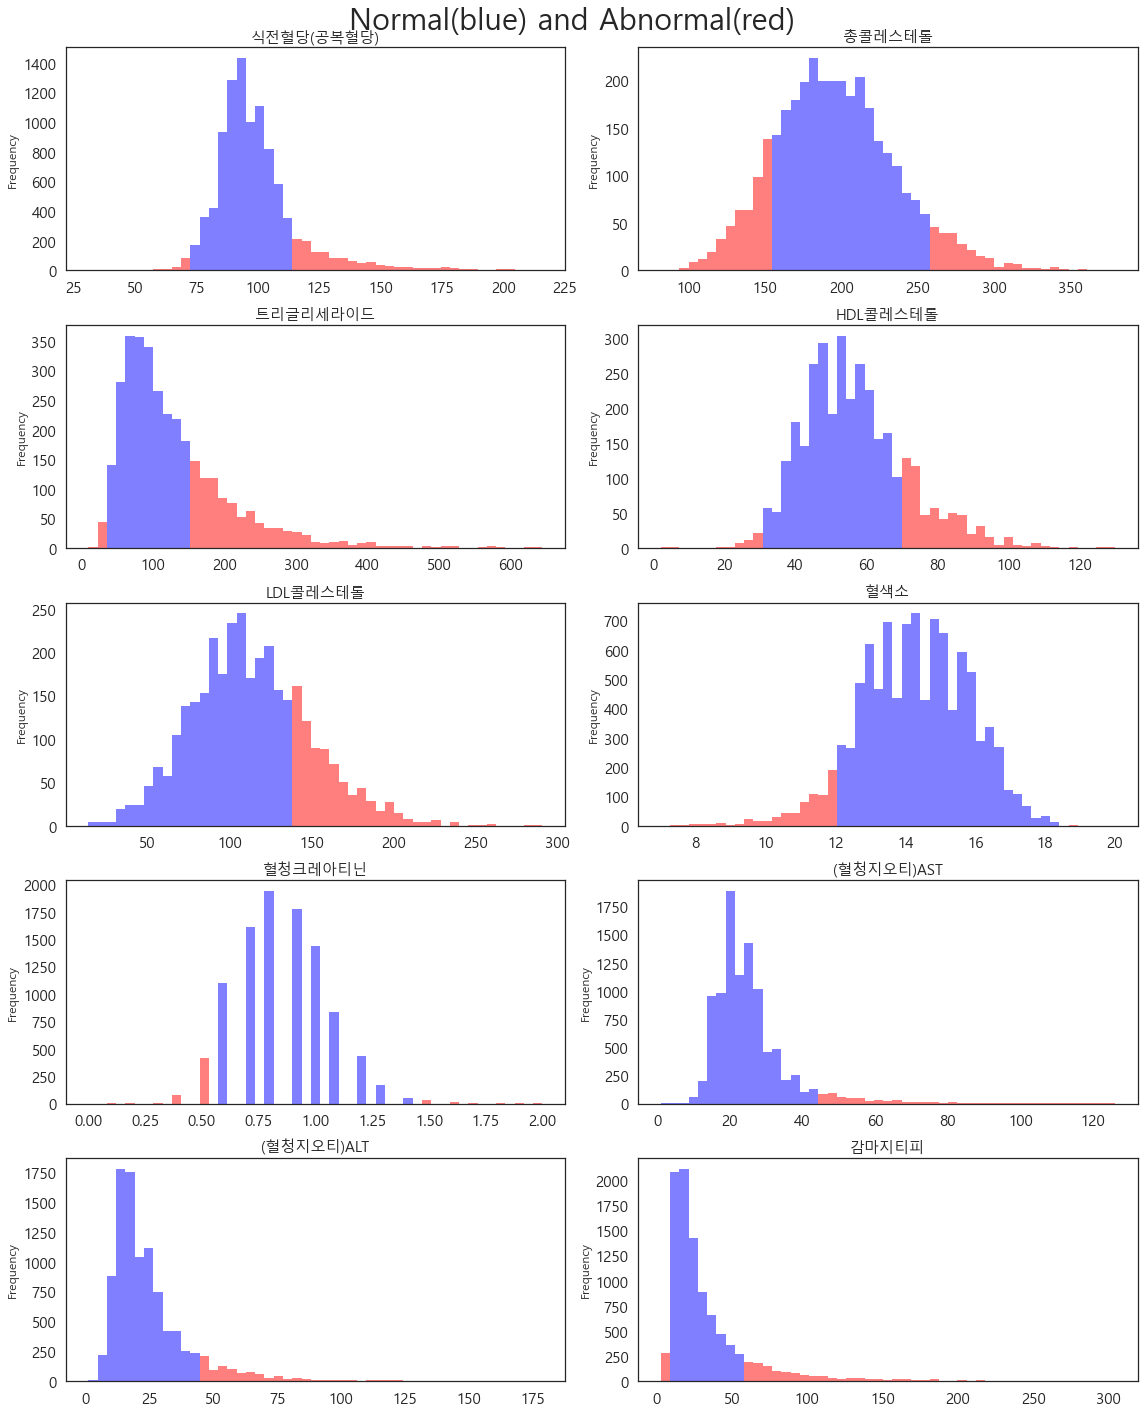

In [124]:
hist_plot(tmp, features, save_full_path='./Data/hist.png')

- 혈액검사 항목 정상치

`-` 공복혈당: 70\~110mg/dL

`-` 총 콜레스테롤: 150\~250mg/dL

`-` 트리글리세라이드: 30\~135mg/dL

`-` HDL 콜레스테롤: 30\~65mg/dL

`-` LDL 콜레스테롤: 0\~130mg/dL

`-` 혈색소: 12\~18g/dL

`-` 혈청크레아티닌: 0.5\~1.4mg/dL

`-` (혈청지오티)AST: 0\~40IU/L

`-` (혈청지오티)ALT: 0\~40IU/L

`-` 감마지티피: 남성 11\~63IU/L, 여성 8\~35IU/L

In [62]:
def corr_heatmap(df_: pd.DataFrame) -> None:
    df = df_.copy()
    df = df.dropna() ## 결측치 제거
    
    features = [df.columns[i] for i, dtype in enumerate(df.dtypes) if dtype.name.find('int') != -1 or dtype.name.find('float') != -1] ## 숫자타입만 사용
    df_corr = df[features]
    corr = df_corr.corr(method='pearson')
    mask = np.triu(np.ones_like(corr, dtype=bool))

    with sns.axes_style('white'):
        matplotlib.rcParams['font.family'] = 'Malgun Gothic' # 한글이 깨지지 않도록 설정
        matplotlib.rcParams['axes.unicode_minus'] = False    # 한글이 깨지지 않도록 설정
        plt.figure(figsize=(17, 15))
        sns.heatmap(data = corr,  mask=mask, annot=True, fmt='.2f', center=0,
                    linewidths=0.5, cmap='coolwarm', cbar_kws={'shrink': .5})
        plt.title('Correlation between features', fontsize=25)

In [69]:
numeric_features = (tmp.columns[(tmp.dtypes == np.int64) | (tmp.dtypes == float)]).tolist()

In [70]:
numeric_features.remove('가입자일련번호')
numeric_features.remove('시도코드')

In [71]:
tmp2 = tmp.copy()

In [72]:
tmp2 = tmp2[numeric_features]

In [73]:
tmp2 = tmp2.dropna()

In [74]:
tmp2 = tmp2[get_not_outlier_index(tmp2)] ## z점수의 절대값이 3을 넘어가는 극단값 제거

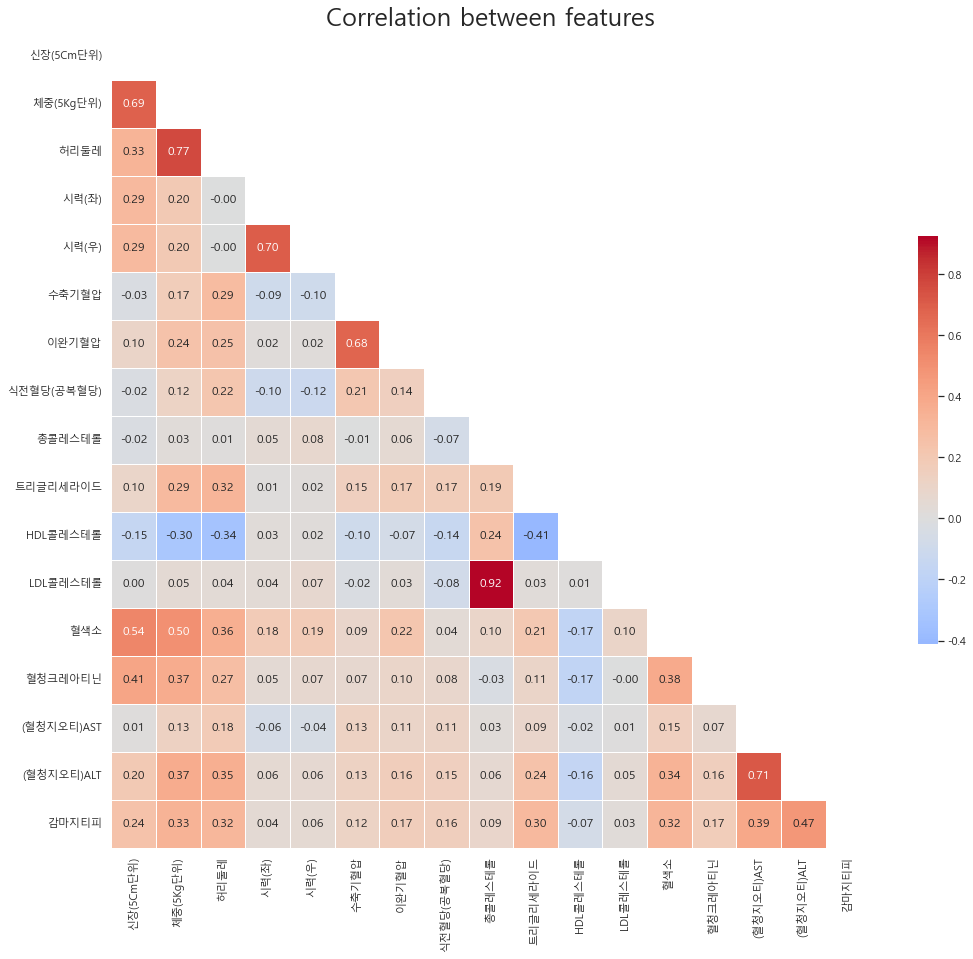

In [637]:
corr_heatmap(tmp2[numeric_features])
plt.savefig('./Data/correlation_heatmap2.png', bbox_inches='tight')

- pair plot

`-` pair plot 그릴 때 kind는 kde로 설정하고 아래삼각행렬에는 스캐터플랏, 위삼각행렬에는 리그레션플랏을 그리자 

`-` 하나의 fig에 3가지 방법으로 시각화 하는 것임

In [76]:
def pair_plot(df_: pd.DataFrame, var_list: list, hue_var: 'str', hue_label: list, hue_order: list, save_full_path: 'str') -> None:
    with sns.axes_style('white'):
        ## font
        matplotlib.rcParams['font.family'] = 'Malgun Gothic' 
        matplotlib.rcParams['axes.unicode_minus'] = False    
        
        ## preprocessing
        df = df_.copy()
        df = df[var_list + [hue_var]]
        df = df.dropna()
        idx = get_not_outlier_index(df[var_list])
        df = df[idx] ## z점수의 절대값이 3을 넘어가는 극단값 제거

        ## bone
        g = sns.PairGrid(data=df, hue=hue_var,
                         vars=var_list,
                         diag_sharey=False,
                         corner=True)

        ## diagonal
        g.map_diag(sns.kdeplot, fill=True)

        ## lower
        g.map_lower(plt.scatter, s=20, alpha=0.3, edgecolor='w')
        g.map_lower(sns.regplot, scatter=False, truncate=False, ci=False)
        g.map_lower(sns.kdeplot, alpha=0.65)


        ## legend
        handles = g._legend_data.values()
        labels = g._legend_data.keys()
        if hue_label is not None:
            labels = hue_label
        
        g.add_legend(label_order=hue_order, legend_data={key: value for key, value in zip(labels, g._legend_data.values())})

        ## title
        plt.suptitle('Pair Plot', fontsize=20)
        plt.tight_layout()

        ## save
        plt.savefig(save_full_path, bbox_inches='tight')

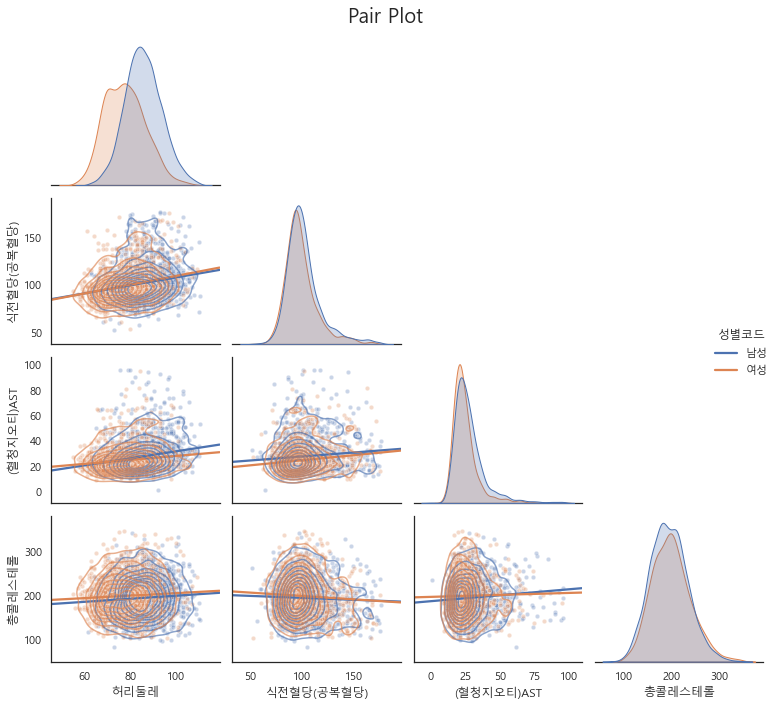

In [648]:
pair_plot(tmp,
          var_list=['허리둘레', '식전혈당(공복혈당)', '(혈청지오티)AST', '총콜레스테롤'],
          hue_var='성별코드',
          hue_label=['남성', '여성'],
          hue_order=['남성', '여성'],
          save_full_path='./Data/pair_plot.png'
         )

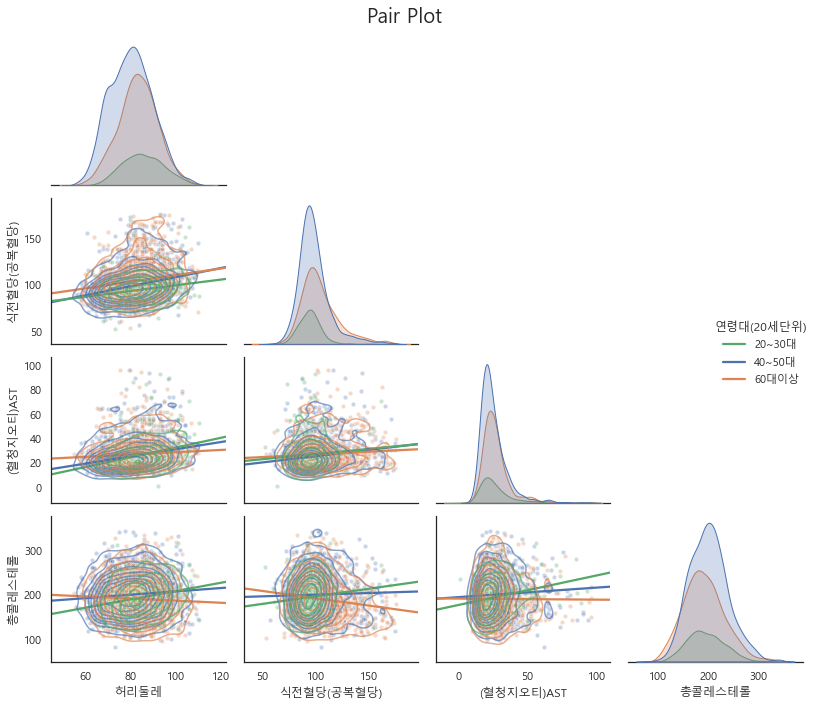

In [668]:
pair_plot(tmp,
          var_list=['허리둘레', '식전혈당(공복혈당)', '(혈청지오티)AST', '총콜레스테롤'],
          hue_var='연령대(20세단위)',
          hue_label=None,
          hue_order=['20~30대', '40~50대', '60대이상'],
          save_full_path='./Data/pair_plot2.png'
         )

`-` 피 검사 목록과 상관관계가 강한 변수(피 검사 제외)는 허리둘레이다

`-` 또한 허리둘레는 몸무게와 상관관계가 강하다

`-` 몸무게는 키와 상관관계가 강하다

`-` 피 검사 변수와의 관계를 확인할 때 허리둘레 변수를 사용하겠다

- anova

`-` 공복혈당, 총 콜레스테롤, (혈청지오티)AST

In [80]:
def anova(df_, var) -> None:        
    ## preprocessing
    df = df_.copy()
    df = df[[var, '연령대(20세단위)']]
    df = df.dropna()
    idx = get_not_outlier_index(df[[var]])
    df = df[idx] ## z점수의 절대값이 3을 넘어가는 이상점 제거
    
    ## anova test
    g1 = df[df['연령대(20세단위)'] == '20~30대'][var]
    g2 = df[df['연령대(20세단위)'] == '40~50대'][var]
    g3 = df[df['연령대(20세단위)'] == '60대이상'][var]
    
    F_statistic, p_val = stats.f_oneway(g1, g2, g3)
    print(var + '에 대한 일원분산분석 결과 : F = {0:.1f}, p = {1:.5f}'.format(F_statistic, p_val))
    if p_val < 0.05:
        print('p-value 값이 충분히 작으므로 그룹의 평균값이 통계적으로 유의미하게 차이납니다.')

In [81]:
anova(tmp, '식전혈당(공복혈당)')
anova(tmp, '총콜레스테롤')
anova(tmp, '(혈청지오티)AST')

식전혈당(공복혈당)에 대한 일원분산분석 결과 : F = 325.1, p = 0.00000
p-value 값이 충분히 작으므로 그룹의 평균값이 통계적으로 유의미하게 차이납니다.
총콜레스테롤에 대한 일원분산분석 결과 : F = 23.6, p = 0.00000
p-value 값이 충분히 작으므로 그룹의 평균값이 통계적으로 유의미하게 차이납니다.
(혈청지오티)AST에 대한 일원분산분석 결과 : F = 93.6, p = 0.00000
p-value 값이 충분히 작으므로 그룹의 평균값이 통계적으로 유의미하게 차이납니다.


- t-test

In [82]:
def t_test(df_, var) -> None:        
    ## preprocessing
    df = df_.copy()
    df = df[[var, '성별코드']]
    df = df.dropna()
    idx = get_not_outlier_index(df[[var]])
    df = df[idx] ## z점수의 절대값이 3을 넘어가는 이상점 제거
    
    ## anova test
    g1 = df[df['성별코드'] == '1'][var]
    g2 = df[df['성별코드'] == '2'][var]

    t_statistic, p_val = stats.ttest_ind(g1, g2)
    print(var + '에 대한 t검정 결과 : F = {0:.1f}, p = {1:.5f}'.format(t_statistic, p_val))
    if p_val < 0.05:
        print('p-value 값이 충분히 작으므로 그룹의 평균값이 통계적으로 유의미하게 차이납니다.')

In [83]:
t_test(tmp, '식전혈당(공복혈당)')
t_test(tmp, '총콜레스테롤')
t_test(tmp, '(혈청지오티)AST')

식전혈당(공복혈당)에 대한 t검정 결과 : F = 14.0, p = 0.00000
p-value 값이 충분히 작으므로 그룹의 평균값이 통계적으로 유의미하게 차이납니다.
총콜레스테롤에 대한 t검정 결과 : F = -3.4, p = 0.00065
p-value 값이 충분히 작으므로 그룹의 평균값이 통계적으로 유의미하게 차이납니다.
(혈청지오티)AST에 대한 t검정 결과 : F = 19.0, p = 0.00000
p-value 값이 충분히 작으므로 그룹의 평균값이 통계적으로 유의미하게 차이납니다.


- 이런 것도 괜찮은 듯

`-` 여기서 허리둘레가 2cm 늘어나면 고혈압 발생 가능성이 현재보다 20%p 상승합니다

`-` 여기서 몸무게가 10kg 늘어나면 혈색소 가능성이 현재보다 25%p 상승합니다

`-` 예측을 할 때 연령대별로 할거니까 연령대별로 시각화해야함

`-` 당연하게도 키가 크면 몸무게가 많이 나가는 경향이 있고

`-` 몸무게가 많이 나가면 허리둘레가 긴 경향이 있고

`-` 허리둘레가 길면 혈압이 높은 경향이 있다

`-` 위에 있는 것들은 당연하기에 굳이 시각화하지 않겠다

- 시력과 혈압 사이의 관계?

`-` 이건 시각화 해보기 전까지는 모른다(이런 것들을 시각화 하겠음)

## 예측 모델 생성

`-` f1 score는 precision 과 recall의 조화평균

In [125]:
def preprocessing(df_: pd.DataFrame) -> pd.DataFrame:
    """분석 하기전에 전처리를 수행"""
    df = df_.copy()
    try:
        df = df.drop(['치석', '치아우식증유무', '음주여부'], axis=1)
    except:
        pass
    df = df.dropna() ## 대략 3300개
    
    ## 설명변수
    df['요단백'] = df['요단백'].apply(lambda x: 1 if x == 1 else 2) ## 음성과 양성
    df['연령대'] = df['연령대'].apply(lambda x: int(x[0]))
        
    ## 반응변수
    df['식전혈당(공복혈당)'] = df['식전혈당(공복혈당)'].apply(lambda x: 0 if x >=70 and x <= 110 else 1) ## 0은 정상 1은 비정상
    df['총콜레스테롤'] = df['총콜레스테롤'].apply(lambda x: 0 if x >=150 and x <= 250 else 1) ## 0은 정상 1은 비정상
    df['트리글리세라이드'] = df['트리글리세라이드'].apply(lambda x: 0 if x >=30 and x <= 135 else 1) ## 0은 정상 1은 비정상
    df['HDL콜레스테롤'] = df['HDL콜레스테롤'].apply(lambda x: 0 if x >=30 and x <= 65 else 1) ## 0은 정상 1은 비정상
    df['LDL콜레스테롤'] = df['LDL콜레스테롤'].apply(lambda x: 0 if x >=0 and x <= 130 else 1) ## 0은 정상 1은 비정상
    df['혈색소'] = df['혈색소'].apply(lambda x: 0 if x >=12 and x <= 18 else 1) ## 0은 정상 1은 비정상
    df['혈청크레아티닌'] = df['혈청크레아티닌'].apply(lambda x: 0 if x >=0.5 and x <= 1.4 else 1) ## 0은 정상 1은 비정상
    df['(혈청지오티)AST'] = df['(혈청지오티)AST'].apply(lambda x: 0 if x >=0 and x <= 40 else 1) ## 0은 정상 1은 비정상
    df['(혈청지오티)ALT'] = df['(혈청지오티)ALT'].apply(lambda x: 0 if x >=0 and x <= 40 else 1) ## 0은 정상 1은 비정상
    
    ### 감마지티피(정상: 남자는 11~63, 여자는 8~35)
    idx = ((df['성별코드'] == 1) & (df['감마지티피'] >=11) & (df['감마지티피'] <= 63)) |\
    ((df['성별코드'] == 2) & (df['감마지티피'] >=8) & (df['감마지티피'] <= 35))
    df.loc[idx, ['감마지티피']] = 0 ## 정상
    df.loc[~idx, ['감마지티피']] = 1 ## 비정상
    
    df = df.rename(columns={'신장(5Cm단위)':'신장',
                            '체중(5Kg단위)':'체중',
                            '식전혈당(공복혈당)':'공복혈당',
                            '(혈청지오티)AST':'AST',
                            '(혈청지오티)ALT':'ALT'})

    return df

In [126]:
tmp3 = preprocessing(temp)

In [127]:
def logistic_regression_analysis(df_, explanatory_vars: list, response_var: str, summary_print=False):
    import statsmodels.formula.api as smf
    df = df_.copy()
    df = df.dropna(subset=explanatory_vars + [response_var])
    
    ## formula
    formula = response_var + '~' + '+'.join(explanatory_vars)
    model = smf.logit(formula=formula, data=df).fit()
    if summary_print:
        model_summary = model.summary()
        print(model_summary, end='\n\n')
    return model

In [128]:
explanatory_vars = ['성별코드', '연령대', '신장', '체중', 
                    '허리둘레', '흡연상태', '수축기혈압',
                    '이완기혈압', '요단백']

In [129]:
response_vars = ['총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤',
                 'LDL콜레스테롤', '공복혈당', '혈색소', 
                 '감마지티피', '혈청크레아티닌', 'AST', 'ALT']

- 정밀도

In [42]:
def get_precision(true, pred, positive_label=1):
    true_positive = 0 ## TP 초기화
    false_positive = 0 ## FP 초기화
    for i, p in enumerate(pred):
        if p == positive_label and true[i] == positive_label: ## TP Case
            true_positive += 1
        elif p == positive_label and true[i] != positive_label: ## FP Case
            false_positive += 1
    return true_positive / (true_positive + false_positive) ## 정밀도(긍정이라 예측한 것 중 실제 긍정의 비율)

- 재현율

In [43]:
def get_recall(true, pred, positive_label=1):
    true_positive = 0 # TP 초기화
    false_negative = 0 # FN 초기화 
    for i, p in enumerate(pred):
        if p == positive_label and true[i] == positive_label: ## TP Case
            true_positive += 1
        elif p != positive_label and true[i] == positive_label: ## FN Case
            false_negative += 1
    return true_positive / (true_positive + false_negative) ## 재현율(실제 긍정 중 긍정이라 예측한 비율)

- f1 score

In [44]:
def get_f1_score(true, pred, positive_label=1):
    precision = get_precision(true, pred, positive_label)
    recall = get_recall(true, pred, positive_label)
    return 2 / (1 / precision + 1 / recall)

In [203]:
def get_logistic_rslt(df_: pd.DataFrame, explanatory_vars: list, response_var: 'str') -> tuple:
    """로지스틱회귀모형을 적합시키고 R^2과 f1-score를 반환하는 함수"""
    model = logistic_regression_analysis(df_, explanatory_vars, response_var)
    
    ## drop na
    df = df_.copy()
    df = df.dropna()
    
    ## R^2
    s = model.summary().tables[0]
    R2 = s[3][3].data
    p_val = s[6][3].data
    
    ## f1 score
    preds = model.predict(df) ## train score
    threshold = 0.25
    pred_labels = preds.apply(lambda x: 1 if x > threshold else 0)
    f1_score = get_f1_score(np.array(df[response_var]), np.array(pred_labels))
    return p_val, R2, f1_score

|반응변수|R-square|f1-score|
|:-:|:-:|:-:|
|총콜레스테롤|0.01467|0.2391|
|트리글리세라이드|0.08088|0.5782|
|HDL콜레스테롤|0.07439|0.4693|
|LDL콜레스테롤|0.01045|0.4698|
|공복혈당|0.1021|0.4207|
|혈색소|0.09872|0.0089|
|감마지티피|0.04911|0.3331|
|혈청크레아티닌|X|X|
|AST|0.03897|0.0581|
|ALT|0.1343|0.4092|

In [204]:
for var in response_vars:
    try:
        p_val, R2, f1_score = get_logistic_rslt(tmp3, explanatory_vars, var)
        print(f'{var} : p_val -> {p_val} R^2 -> {R2} f1-score -> {f1_score:.4f}\n')
    except:
        print(f'{var} : 주어진 모델은 예측력이 없습니다\n')

Optimization terminated successfully.
         Current function value: 0.493310
         Iterations 6
총콜레스테롤 : p_val -> 2.055e-07 R^2 -> 0.01467 f1-score -> 0.2391

Optimization terminated successfully.
         Current function value: 0.596665
         Iterations 5
트리글리세라이드 : p_val -> 3.031e-69 R^2 -> 0.08088 f1-score -> 0.5782

Optimization terminated successfully.
         Current function value: 0.519729
         Iterations 6
HDL콜레스테롤 : p_val -> 3.396e-54 R^2 -> 0.07439 f1-score -> 0.4693

Optimization terminated successfully.
         Current function value: 0.604076
         Iterations 5
LDL콜레스테롤 : p_val -> 3.128e-06 R^2 -> 0.01045 f1-score -> 0.4698

Optimization terminated successfully.
         Current function value: 0.452915
         Iterations 6
공복혈당 : p_val -> 8.125e-68 R^2 -> 0.1021 f1-score -> 0.4207

Optimization terminated successfully.
         Current function value: 0.216308
         Iterations 8
혈색소 : p_val -> 4.037e-29 R^2 -> 0.09872 f1-score -> 0.0089

Optimizati

`-` f1 score가 제일 높은 반응변수는 트리글리세라이드이다

## 결론

`-` 혈액검사 항목의 값을 혈액검사를 하지않고 얻을 수 있는 데이터로 예측하는 것은 매우 어렵다

`-` 그래서 정상과 비정상을 구분하는 모델을 만들었지만 이 역시 성능은 좋지 않았다

`-` 애초에 정상과 비정상을 구분하려면 값을 추론해야 한다

`-` 그런데 이 값을 잘 구하지 못하니 오차가 클 수 밖에 없다

`-` 오차를 구간화를 통해 줄이고자 했지만 결과는 안좋았다

`-` f1 score가 제일 높은 혈액검사 항목은 트리글리세라이드이다

`-` 사실, 혈액 검사를 한다면 여러가지 항목에 대하여 검사를 할 것이므로

`-` 트리글리세라이드 수치가 비정상일 확률이 높다면 혈액 검사를 하여 다른 항목들도 같이 검사하는 것이 낫다